In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import operator

import peakutils

import string
import nltk
stopwords = nltk.corpus.stopwords.words('english')

import operator
from collections import Counter

import scipy.stats
from scipy.optimize import curve_fit
from scipy.misc import factorial

import pickle
from sklearn.feature_extraction.text import CountVectorizer

from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson, Logit
from scipy.stats import binom, nbinom

import plotly
import plotly.plotly as py
from plotly import tools

import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='sreejith_s', api_key='rcet0rTqFCc3WeOzWTjv')

from unicodedata import category
from tqdm import tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set_style('white')
import matplotlib.pylab as plt

In [4]:
filename = "/mnt/disks/vault/analysis-data/interdisciplinary-novelty-analysis/corrected-entropy-analysis/word-journey-data.pql"
data_grouped_by_year_label = pd.read_pickle(filename)

discipline = "Transportation"
input_ = data_grouped_by_year_label[data_grouped_by_year_label.Label == discipline]
data_grouped_by_year_label = None

vectorizer = CountVectorizer()
vectorized_words = vectorizer.fit_transform(input_.title_words)

vectorized_wordarray = vectorized_words.toarray()
document_frequency = (vectorized_wordarray != 0).sum(0).tolist()
document_frequency_log =  [np.log(x) for x in document_frequency]

#2. Term Frequency - Number of times in which a word appears in a document
term_frequency = vectorized_words.sum(axis=0).reshape(-1,).tolist()[0]
term_frequency_log = [np.log(x) for x in term_frequency]

input_["number_of_pubs"] = input_["title_without_stopwords"].progress_apply(lambda x: len(x))
input_["word_count"] = input_["title_words"].progress_apply(lambda x: len(x.split()))

Progress: 100%|██████████| 62/62 [00:00<00:00, 1747.64it/s]


In [19]:
input_.head()

,index,Label,PubYear,title_without_stopwords,cleaned_titles,title_words_,title_words,number_of_pubs,word_count
19276,19276,Transportation,1956,[fitzgerald john f expressway boston central ...,"[turnpike expressway system oklahoma plan, for...",turnpike expressway system oklahoma plan forec...,turnpike expressway system oklahoma plan forec...,82,183
19277,19277,Transportation,1957,"[scientific fleet management state california,...","[connecticuts plan meet impact highway, urban ...",connecticuts plan meet impact highway urban ro...,connecticuts plan meet impact highway urban ro...,84,197
19278,19278,Transportation,1958,"[there better years ahead toll road financing,...",[benefits complete programs urban transportati...,benefits complete programs urban transportatio...,benefits complete programs urban transportatio...,84,178
19279,19279,Transportation,1959,[research highway planning research constructi...,"[new orleans 7 cent fare, lansings one way str...",new orleans 7 cent fare lansings one way stree...,new orleans cent fare lansings one way street ...,90,193
19280,19280,Transportation,1960,"[accident prevention arizona, accident prevent...",[traffic safety nations capital moves steadily...,traffic safety nations capital moves steadily ...,traffic safety nations capital moves steadily ...,84,191


Text(0,0.5,'number of Publications')

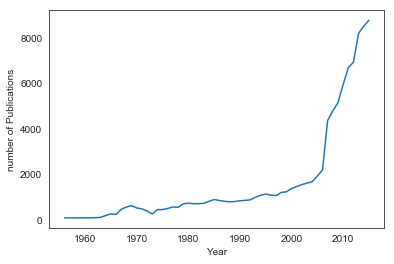

In [12]:
plt.plot(input_.PubYear[:60], input_.number_of_pubs[:60])

plt.xlabel("Year")
plt.ylabel("number of Publications")

In [13]:
count_matrix = vectorized_words.toarray()

uniques = []
counts = []
yearly_word_frequency_variations = []
avg_variations_for_freq = []

for i in range(count_matrix.shape[0]):
    unique_, counts_tmp = np.unique(count_matrix[i:i+1,:], return_counts=True)    
    counts_ = list(map(np.log, counts_tmp))
    uniques.append(unique_)
    counts.append(counts_)
    
for index in tqdm(range(vectorized_wordarray.shape[0] - 1)):
    
    # take two consecutive years
    tmp_ = vectorized_wordarray[index:index+2]
    
    #unique counts for the first year
    unique_counts = np.unique(tmp_[0]) 
    
    yearly_avg_variations_for_freq = {}
    word_freq_variations = []
    
    word_freq_variations.append(tmp_[1] - tmp_[0])
    
    yearly_word_frequency_variations.append(word_freq_variations)
    
    for uniq in unique_counts:
        # find the indices where the value == uniq
        indices, = np.where(tmp_[0] == uniq)
        
        # find the values in the next year where those indices are
        # variations of words with that `uniq` count
        transition_values = tmp_[1][indices]
        variations = transition_values - uniq
        
        # mean variation of words with that `uniq` count
        mean_variation = np.mean(variations)
        
        # make a list of mean variations
        yearly_avg_variations_for_freq[uniq] = round(mean_variation, 3)
    
    avg_variations_for_freq.append(yearly_avg_variations_for_freq)

100%|██████████| 61/61 [00:00<00:00, 500.47it/s]


In [14]:
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

__Year: 2015__ - _Poisson and Negative Binomial_

In [15]:
def get_word_variations(N, K):
    
    freq_current = list(vectorized_wordarray[N:N+1,:][0])
    freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
    indices = [i for i, x in enumerate(freq_current) if x == K]
    change_in_values = [freq_next[i] for i in indices]
    variations = [j - K for j in change_in_values]
    sum_ = sum(dict(Counter(variations)).values())
    X = [x + K for x,y in dict(Counter(variations)).items()]
    Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
    
    return change_in_values, X, Y

In [16]:
def get_poisson_pmf(change_in_values, X):
    
    poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
    poissonRes = poissonModel.fit()
    poissonModel.loglike(poissonRes.params)

    lambda_ = np.exp(poissonRes.params[0])
    Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
    return Y_poiss

In [17]:
def get_negative_binomial_fit(change_in_values, X):
    
    loglike_method = 'nb2'  # or use 'nb2'
    model = NegativeBinomial(change_in_values, np.ones_like(change_in_values))
    binomial_result = model.fit()
    mu = np.exp(binomial_result.params[0])   
    alpha = binomial_result.params[1]

    if loglike_method == 'nb1':
        Q = 1
    elif loglike_method == 'nb2':    
        Q = 0
    size = 1. / alpha * mu**Q
    prob = size / (size + mu)
    dist_est = nbinom(size, prob)
    
    return dist_est, [dist_est.pmf(k) for k in sorted(X)]    

In [18]:
def plot(X_,Y_, ax=None, title="", xlabel="", ylabel="", dist=None, **kwargs):

    ax = ax or plt.gca()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if dist:
        ax.axvline(dist.mean(), color="black")
    return ax.scatter(X_,Y_, **kwargs)

In [20]:
N = 59
K = 3
change_in_values, X, Y = get_word_variations(N, K)

# Poison Fit
Y_poiss = get_poisson_pmf(change_in_values, X)

# Negative Binomial
dist_est, Y_neg_binomial = get_negative_binomial_fit(change_in_values, X)

Optimization terminated successfully.
         Current function value: 2.361935
         Iterations 1
Optimization terminated successfully.
         Current function value: 2.174969
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7


<Figure size 1296x720 with 0 Axes>

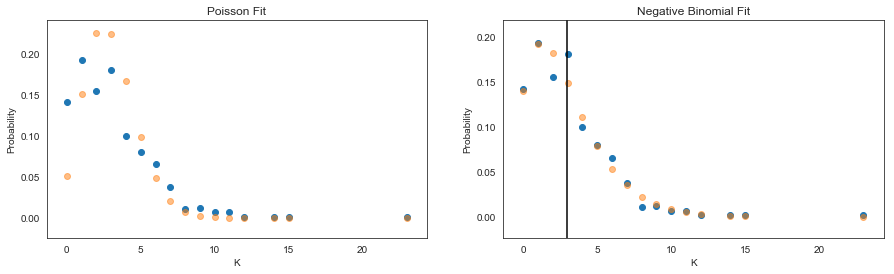

In [21]:
f = plt.figure(figsize=(18, 10))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))

plot(X,Y, ax1)
plot(X,Y_poiss, ax1, title="Poisson Fit", xlabel="K", ylabel="Probability", alpha=0.5)

plot(X,Y, ax2)
plot(sorted(X),Y_neg_binomial, ax2, 
     title="Negative Binomial Fit", 
     xlabel="K", 
     ylabel="Probability", 
     dist = dist_est,
     alpha=0.5)

In [22]:
K = 5
change_in_values, X, Y = get_word_variations(N, K)
Y_poiss = get_poisson_pmf(change_in_values, X)
dist_est, Y_neg_binomial = get_negative_binomial_fit(change_in_values, X)

Optimization terminated successfully.
         Current function value: 2.821424
         Iterations 1
Optimization terminated successfully.
         Current function value: 2.554623
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7


<Figure size 1296x720 with 0 Axes>

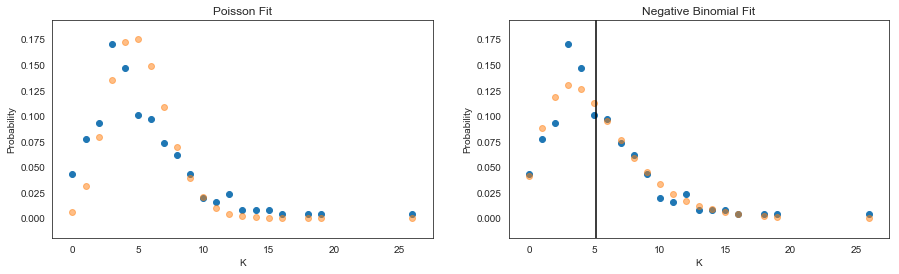

In [23]:
f = plt.figure(figsize=(18, 10))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
plot(X,Y, ax1)
plot(X,Y_poiss, ax1, title="Poisson Fit", xlabel="K", ylabel="Probability", alpha=0.5)
plot(X,Y, ax2)
plot(sorted(X),Y_neg_binomial, ax2, 
     title="Negative Binomial Fit", 
     xlabel="K", 
     ylabel="Probability", 
     dist = dist_est,
     alpha=0.5)

In [24]:
K = 10
change_in_values, X, Y = get_word_variations(N, K)

# Poison Fit
Y_poiss = get_poisson_pmf(change_in_values, X)

# Negative Binomial
dist_est, Y_neg_binomial = get_negative_binomial_fit(change_in_values, X)

Optimization terminated successfully.
         Current function value: 2.857842
         Iterations 1
Optimization terminated successfully.
         Current function value: 2.774310
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8


<Figure size 1296x720 with 0 Axes>

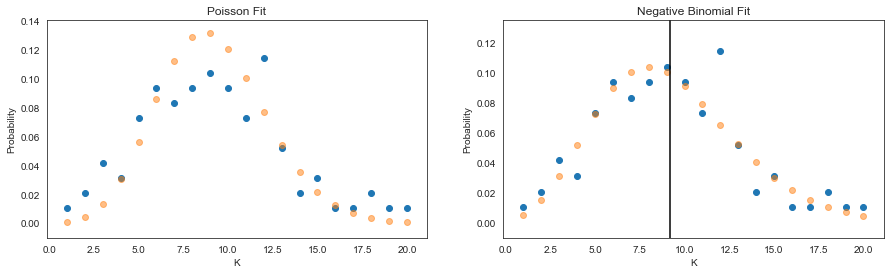

In [25]:
f = plt.figure(figsize=(18, 10))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
plot(X,Y, ax1)
plot(X,Y_poiss, ax1, title="Poisson Fit", xlabel="K", ylabel="Probability", alpha=0.5)
plot(X,Y, ax2)
plot(sorted(X),Y_neg_binomial, ax2, 
     title="Negative Binomial Fit", 
     xlabel="K", 
     ylabel="Probability", 
     dist = dist_est,
     alpha=0.5)

In [26]:
K = 15
change_in_values, X, Y = get_word_variations(N, K)

# Poison Fit
Y_poiss = get_poisson_pmf(change_in_values, X)

# Negative Binomial
dist_est, Y_neg_binomial = get_negative_binomial_fit(change_in_values, X)

Optimization terminated successfully.
         Current function value: 3.041860
         Iterations 1
Optimization terminated successfully.
         Current function value: 3.003700
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8


<Figure size 1296x720 with 0 Axes>

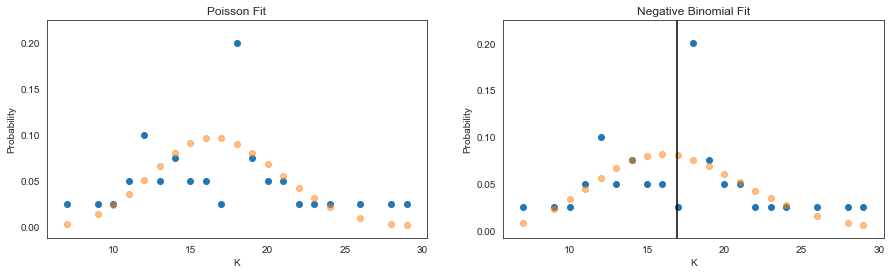

In [27]:
f = plt.figure(figsize=(18, 10))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))

plot(X,Y, ax1)
plot(X,Y_poiss, ax1, title="Poisson Fit", xlabel="K", ylabel="Probability", alpha=0.5)
plot(X,Y, ax2)
plot(sorted(X),Y_neg_binomial, ax2, 
     title="Negative Binomial Fit", 
     xlabel="K", 
     ylabel="Probability", 
     dist = dist_est,
     alpha=0.5)